# Proyecto 05

---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **Daniela Fonseca Zumbado, Emmanuel Solano Monge y Gabriel Torres Garbanzo.**
- Carné: **B93070, B97580 y B97828.**
- Grupo: **1/2**


## Parte 1

### Información derivada del enunciado:

- $\lambda = 4$ personas por minuto.
- $\nu = 0.25$ personas por minuto.
- No se deben exceder las 50 personas en fila durante el 95% del tiempo de servicio, por lo tanto, $i = 50$.

### Determinación teórica de la cantidad de servidores $s$:

Se observa que se trata de un proceso $\textbf{M/M/s}$, para el cual, se necesita que el sistema no exceda las 50 personas durante el 95% del tiempo, entonces:

$$
P( \text{51 o más clientes en el sistema} ) = \sum_{i=51}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{50} (1 - \rho) \rho^i = \rho^{50}
$$

Entonces, sabemos que $\rho^{a} = \big(\frac{\lambda}{s\nu}\big)^a$ y sabemos que se requiere una probabilidad menor o igual al 5%, pues como se mencionó al inicio, en el 95% del tiempo no se debe exceder el límite de 50 personas, con lo cual se tiene:

$$
P( \text{51 o más clientes en el sistema} ) = \rho^{50} = \big(\frac{\lambda}{s\nu}\big)^{50} \Leftrightarrow \rho^{50} = \frac{\lambda^{50}}{s^{50}\nu^{50}} \leq 0.05
$$

De la inecuación anterior, se nota que tanto $\lambda$ como $\nu$ tienen valores conocidos, por ende, basta con despejar la cantidad de servidores $s$ tal que:

$$
s^{50} \geq \frac{\lambda^{50}}{0.05\cdot\nu^{50}} \Leftrightarrow s \geq \bigg(\frac{\lambda^{50}}{0.05\cdot\nu^{50}}\bigg)^{\frac{1}{50}} \Leftrightarrow s \geq \bigg(\frac{(4)^{50}}{0.05\cdot(0.25)^{50}}\bigg)^{\frac{1}{50}} \Leftrightarrow s \geq 16.9879 \approx 17
$$

Por lo tanto, para que se cumplan las condiciones solicitadas se requieren al menos 17 servidores.

## Parte 2

Se crea una función que corrobore la cantidad de servidores necesarios y que a su vez grafique los clientes en el sistema con respecto al tiempo.

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def verificacion_graficacion(N, lamb, nu, serv):

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale=1/lamb)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale=1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Tiempos de fin de servicio de servidores
    servidores = np.zeros(serv)

    # Inicialización de los tiempos de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Se asigna el primer servidor
    servidores[0] = fin

    # Tiempos de atención de cada cliente
    t_aten = [inicio]

    for i in range(1, N):
        
        serv_deso = np.where(servidores <= t_llegadas[i])[0] # Servidores desocupados
        
        if serv_deso.size == 0:
            inicio = np.min(servidores) + 1
            fin = inicio + t_servicio[i]  
            # Se fija el servidor
            mini = np.min(servidores)
            serv_1 = servidores.tolist().index(mini)
            servidores[serv_1] = fin
            
        else: 
            inicio = t_llegadas[i]
            fin = inicio + t_servicio[i]
            # Se fija el servidor
            serv_1 = serv_deso[0]
            servidores[serv_1] = fin

        t_aten.append(inicio.astype(int))

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_aten[-1] + max(t_servicio) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_aten[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 51

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c  # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P:
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lamb*60))
    print('Parámetro nu =', str(nu*60))
    print('Cantidad de servidores =', str(serv))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-1))
    print('\t {:0.2f}%'.format(100*fraccion))

    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.')
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 15000))
    plt.show()

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.82 horas.


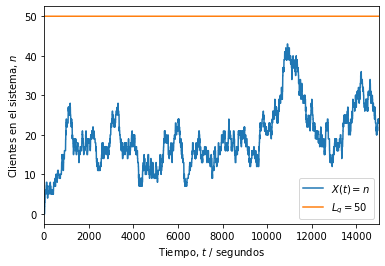

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 16
Tiempo con más de 50 solicitudes en fila:
	 33.40%
	 No cumple con la especificación.
Simulación es equivalente a 4.80 horas.


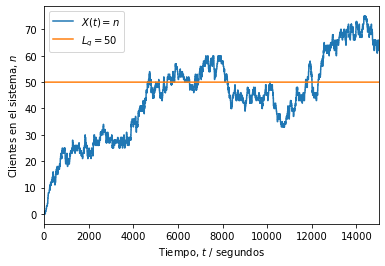

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 15
Tiempo con más de 50 solicitudes en fila:
	 33.91%
	 No cumple con la especificación.
Simulación es equivalente a 5.12 horas.


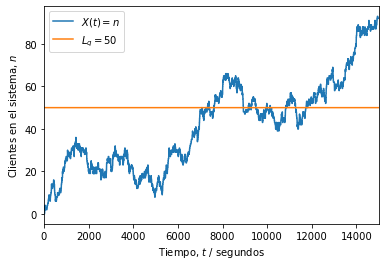

In [7]:
# Se establecen los valores de las cantidades requeridas para la simulación
N = 1000  # Número de clientes
lamb = 4/60  # Tasa de llegada en personas/segundo
nu = 0.25/60  # Tasa de partida en personas/segundo
servidores_1 = 17 # Cantidad de servidores para prueba
servidores_2 = 16 # Cantidad de servidores para prueba
servidores_3 = 15 # Cantidad de servidores para prueba

# Se llama a la función verificacion_graficacion para ver si 17 servidores son necesarios
verificacion_graficacion(N, lamb, nu, servidores_1)

# Se llama a la función verificacion_graficacion para ver si 16 servidores son necesarios
verificacion_graficacion(N, lamb, nu, servidores_2)

# Se llama a la función verificacion_graficacion para ver si 15 servidores son necesarios
verificacion_graficacion(N, lamb, nu, servidores_3)

#### Nota:
Por la desigualdad de la cantidad de servidores: $s \geq 16.9879$ es posible que el sistema cumpla con los requesitos para menos de $17$ servidores, por esa razón con $s=16$ es posible que para se cumpla con la especificación.